# 01 - Exploratory Data Analysis

This notebook explores the MIMIC-IV data for survival analysis.


## Setup

Import required libraries and set up the environment.


In [3]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

%matplotlib inline

print("Libraries loaded successfully!")


Libraries loaded successfully!


## Load Data

Load the MIMIC-IV Demo data files.


In [4]:
# Set data directory
DATA_DIR = Path('../data/raw/mimic-iv-demo/hosp')

# Load data files
admissions = pd.read_csv(DATA_DIR / 'admissions.csv.gz', compression='gzip')
patients = pd.read_csv(DATA_DIR / 'patients.csv.gz', compression='gzip')
diagnoses_icd = pd.read_csv(DATA_DIR / 'diagnoses_icd.csv.gz', compression='gzip')
d_labitems = pd.read_csv(DATA_DIR / 'd_labitems.csv.gz', compression='gzip')

print("Data loaded successfully!")
print(f"\nAdmissions: {len(admissions):,} rows")
print(f"Patients: {len(patients):,} rows")
print(f"Diagnoses (ICD): {len(diagnoses_icd):,} rows")
print(f"Lab Items Dictionary: {len(d_labitems):,} rows")


Data loaded successfully!

Admissions: 275 rows
Patients: 100 rows
Diagnoses (ICD): 4,506 rows
Lab Items Dictionary: 1,622 rows


## 1. Admissions Data

Explore the admissions data structure and key variables.


In [5]:
# Display basic info
print("Admissions Data Structure:")
print("=" * 60)
admissions.info()
print("\n" + "=" * 60)
print("\nFirst few rows:")
admissions.head()


Admissions Data Structure:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275 entries, 0 to 274
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   subject_id            275 non-null    int64 
 1   hadm_id               275 non-null    int64 
 2   admittime             275 non-null    object
 3   dischtime             275 non-null    object
 4   deathtime             15 non-null     object
 5   admission_type        275 non-null    object
 6   admit_provider_id     275 non-null    object
 7   admission_location    275 non-null    object
 8   discharge_location    233 non-null    object
 9   insurance             275 non-null    object
 10  language              275 non-null    object
 11  marital_status        263 non-null    object
 12  race                  275 non-null    object
 13  edregtime             182 non-null    object
 14  edouttime             182 non-null    object
 15  hospital_expi

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,language,marital_status,race,edregtime,edouttime,hospital_expire_flag
0,10004235,24181354,2196-02-24 14:38:00,2196-03-04 14:02:00,NaN,URGENT,P03YMR,TRANSFER FROM HOSPITAL,SKILLED NURSING FACILITY,Medicaid,ENGLISH,SINGLE,BLACK/CAPE VERDEAN,2196-02-24 12:15:00,2196-02-24 17:07:00,0
1,10009628,25926192,2153-09-17 17:08:00,2153-09-25 13:20:00,NaN,URGENT,P41R5N,TRANSFER FROM HOSPITAL,HOME HEALTH CARE,Medicaid,?,MARRIED,HISPANIC/LATINO - PUERTO RICAN,NaN,NaN,0
2,10018081,23983182,2134-08-18 02:02:00,2134-08-23 19:35:00,NaN,URGENT,P233F6,TRANSFER FROM HOSPITAL,SKILLED NURSING FACILITY,Medicare,ENGLISH,MARRIED,WHITE,2134-08-17 16:24:00,2134-08-18 03:15:00,0
3,10006053,22942076,2111-11-13 23:39:00,2111-11-15 17:20:00,2111-11-15 17:20:00,URGENT,P38TI6,TRANSFER FROM HOSPITAL,DIED,Medicaid,ENGLISH,NaN,UNKNOWN,NaN,NaN,1
4,10031404,21606243,2113-08-04 18:46:00,2113-08-06 20:57:00,NaN,URGENT,P07HDB,TRANSFER FROM HOSPITAL,HOME,Other,ENGLISH,WIDOWED,WHITE,NaN,NaN,0


In [6]:
# Parse datetime columns
admissions['admittime'] = pd.to_datetime(admissions['admittime'])
admissions['dischtime'] = pd.to_datetime(admissions['dischtime'])
admissions['deathtime'] = pd.to_datetime(admissions['deathtime'])
admissions['edregtime'] = pd.to_datetime(admissions['edregtime'])
admissions['edouttime'] = pd.to_datetime(admissions['edouttime'])

# Compute length of stay
admissions['los_days'] = (admissions['dischtime'] - admissions['admittime']).dt.total_seconds() / (24 * 3600)

print("DateTime columns parsed and LOS computed!")
admissions[['admittime', 'dischtime', 'los_days']].head()


DateTime columns parsed and LOS computed!


,admittime,dischtime,los_days
0,2196-02-24 14:38:00,2196-03-04 14:02:00,8.975000
1,2153-09-17 17:08:00,2153-09-25 13:20:00,7.841667
2,2134-08-18 02:02:00,2134-08-23 19:35:00,5.731250
3,2111-11-13 23:39:00,2111-11-15 17:20:00,1.736806
4,2113-08-04 18:46:00,2113-08-06 20:57:00,2.090972


In [7]:
# Key statistics
print("Admissions Summary Statistics:")
print("=" * 60)
print(f"Total admissions: {len(admissions):,}")
print(f"Unique patients: {admissions['subject_id'].nunique():,}")
print(f"Admissions per patient (mean): {len(admissions) / admissions['subject_id'].nunique():.2f}")
print(f"\nDate range: {admissions['admittime'].min()} to {admissions['admittime'].max()}")
print(f"\nIn-hospital deaths: {admissions['hospital_expire_flag'].sum():,} ({admissions['hospital_expire_flag'].mean()*100:.1f}%)")
print(f"\nLength of Stay (days):")
print(admissions['los_days'].describe())


Admissions Summary Statistics:
Total admissions: 275
Unique patients: 100
Admissions per patient (mean): 2.75

Date range: 2110-04-11 15:08:00 to 2201-12-11 12:00:00

In-hospital deaths: 15 (5.5%)

Length of Stay (days):
count    275.000000
mean       6.875530
std        6.733832
min        0.046528
25%        2.692014
50%        4.852778
75%        8.768403
max       44.927778
Name: los_days, dtype: float64


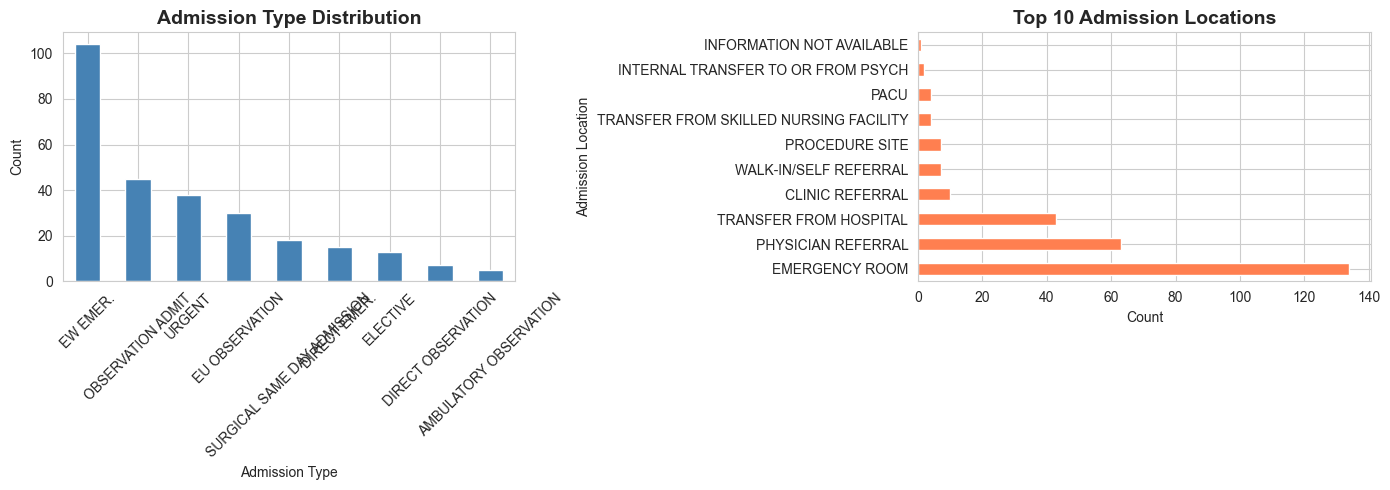

In [8]:
# Visualize admission types
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Admission type
admissions['admission_type'].value_counts().plot(kind='bar', ax=axes[0], color='steelblue')
axes[0].set_title('Admission Type Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Admission Type')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)

# Admission location
admissions['admission_location'].value_counts().head(10).plot(kind='barh', ax=axes[1], color='coral')
axes[1].set_title('Top 10 Admission Locations', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Count')
axes[1].set_ylabel('Admission Location')

plt.tight_layout()
plt.show()


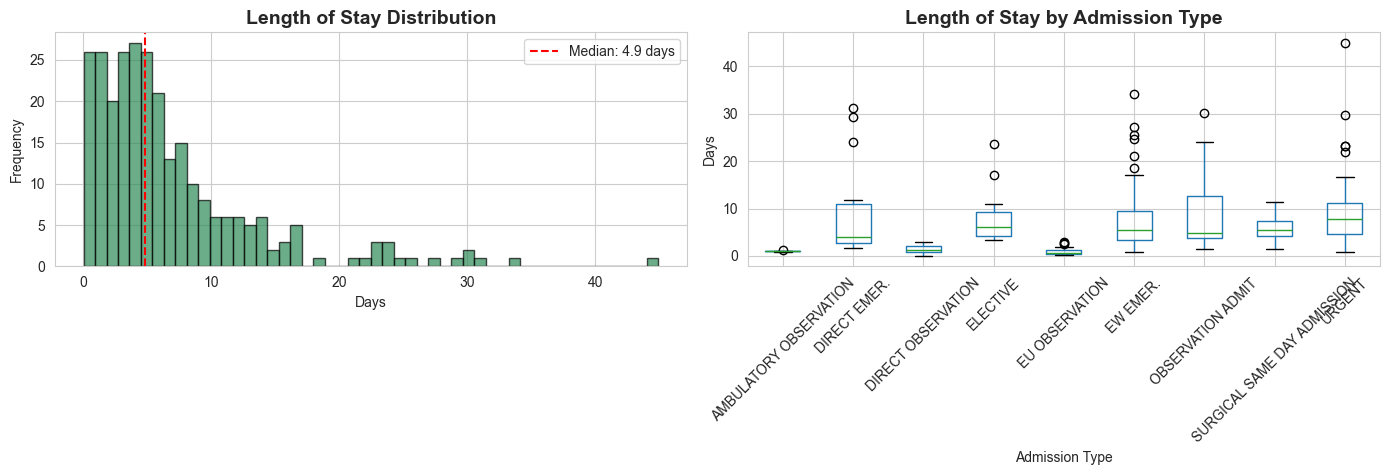

In [9]:
# Length of stay distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(admissions['los_days'], bins=50, color='seagreen', alpha=0.7, edgecolor='black')
axes[0].set_title('Length of Stay Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Days')
axes[0].set_ylabel('Frequency')
axes[0].axvline(admissions['los_days'].median(), color='red', linestyle='--', label=f'Median: {admissions["los_days"].median():.1f} days')
axes[0].legend()

# Box plot by admission type
admissions.boxplot(column='los_days', by='admission_type', ax=axes[1])
axes[1].set_title('Length of Stay by Admission Type', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Admission Type')
axes[1].set_ylabel('Days')
axes[1].tick_params(axis='x', rotation=45)
plt.suptitle('')  # Remove default title

plt.tight_layout()
plt.show()



Discharge Location Distribution:
discharge_location
HOME HEALTH CARE                76
HOME                            72
SKILLED NURSING FACILITY        36
DIED                            15
REHAB                           13
CHRONIC/LONG TERM ACUTE CARE     9
HOSPICE                          5
AGAINST ADVICE                   4
PSYCH FACILITY                   2
ACUTE HOSPITAL                   1
Name: count, dtype: int64


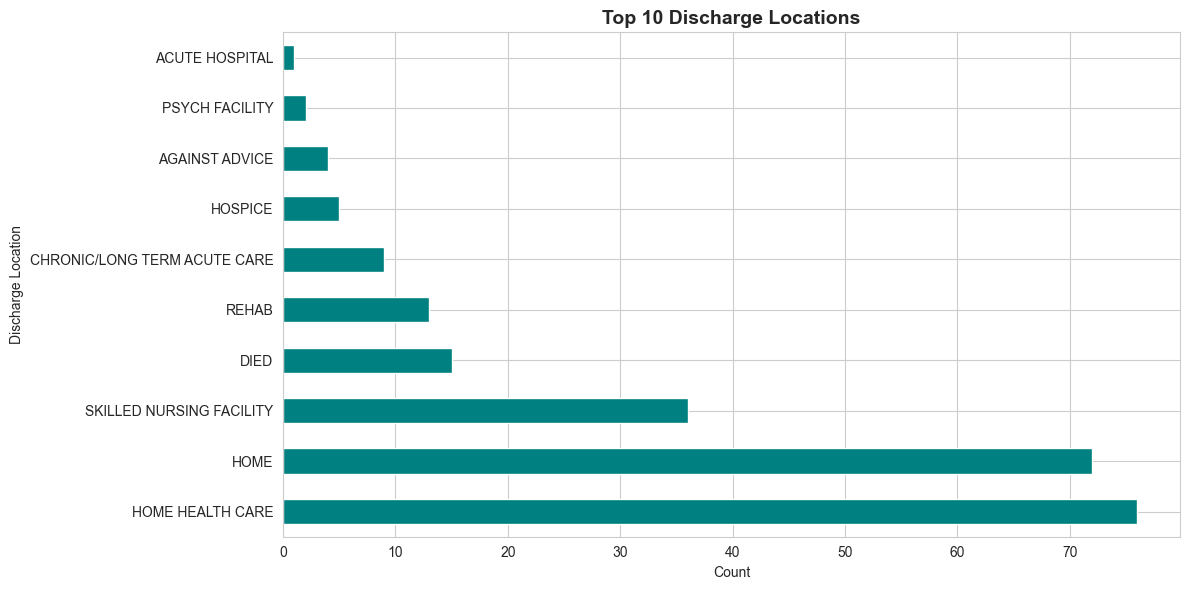

In [10]:
# Discharge locations
print("\nDischarge Location Distribution:")
print("=" * 60)
discharge_counts = admissions['discharge_location'].value_counts()
print(discharge_counts)

# Visualize
plt.figure(figsize=(12, 6))
discharge_counts.head(10).plot(kind='barh', color='teal')
plt.title('Top 10 Discharge Locations', fontsize=14, fontweight='bold')
plt.xlabel('Count')
plt.ylabel('Discharge Location')
plt.tight_layout()
plt.show()


## 2. Patient Demographics

Explore patient demographics and characteristics.


In [11]:
# Display patient data
print("Patients Data Structure:")
print("=" * 60)
patients.info()
print("\n" + "=" * 60)
print("\nFirst few rows:")
patients.head()


Patients Data Structure:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subject_id         100 non-null    int64 
 1   gender             100 non-null    object
 2   anchor_age         100 non-null    int64 
 3   anchor_year        100 non-null    int64 
 4   anchor_year_group  100 non-null    object
 5   dod                31 non-null     object
dtypes: int64(3), object(3)
memory usage: 4.8+ KB


First few rows:


,subject_id,gender,anchor_age,anchor_year,anchor_year_group,dod
0,10014729,F,21,2125,2011 - 2013,NaN
1,10003400,F,72,2134,2011 - 2013,2137-09-02
2,10002428,F,80,2155,2011 - 2013,NaN
3,10032725,F,38,2143,2011 - 2013,2143-03-30
4,10027445,F,48,2142,2011 - 2013,2146-02-09


In [12]:
# Merge admissions with patient demographics
df = admissions.merge(patients, on='subject_id', how='left')

# Compute age at admission
df['age_at_admission'] = df['anchor_age'] + (df['admittime'].dt.year - df['anchor_year'])

print("Patient Demographics Summary:")
print("=" * 60)
print(f"Total unique patients: {df['subject_id'].nunique():,}")
print(f"\nGender distribution:")
print(df.groupby('subject_id')['gender'].first().value_counts())
print(f"\nAge at admission (years):")
print(df['age_at_admission'].describe())


Patient Demographics Summary:
Total unique patients: 100

Gender distribution:
gender
M    57
F    43
Name: count, dtype: int64

Age at admission (years):
count    275.000000
mean      62.727273
std       14.479352
min       21.000000
25%       53.000000
50%       63.000000
75%       72.000000
max       93.000000
Name: age_at_admission, dtype: float64


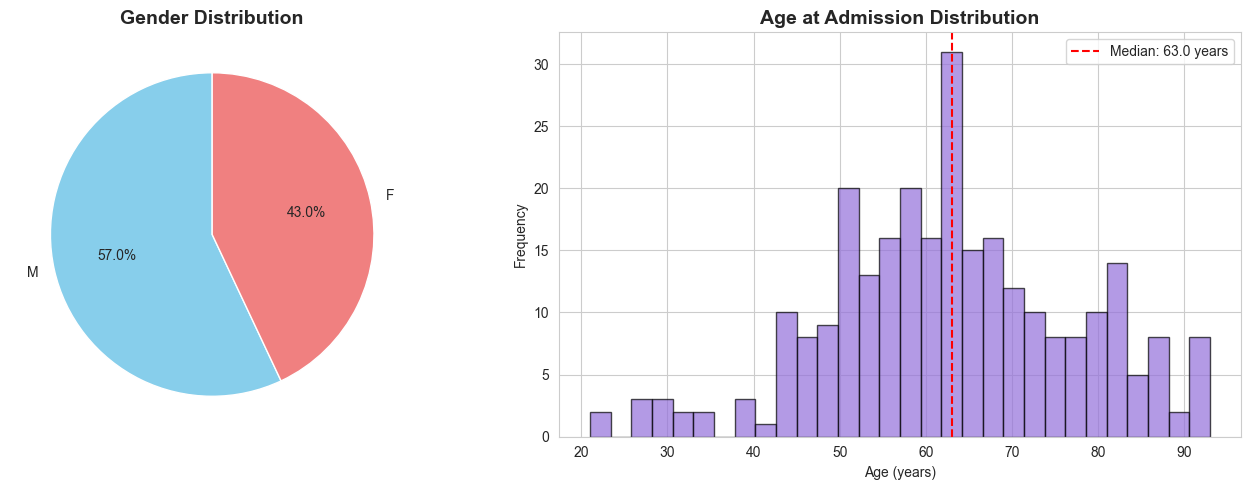

In [14]:
# Visualize demographics
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gender distribution
gender_counts = df.groupby('subject_id')['gender'].first().value_counts()
axes[0].pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=90, colors=['skyblue', 'lightcoral'])
axes[0].set_title('Gender Distribution', fontsize=14, fontweight='bold')

# Age distribution
axes[1].hist(df['age_at_admission'], bins=30, color='mediumpurple', alpha=0.7, edgecolor='black')
axes[1].set_title('Age at Admission Distribution', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Age (years)')
axes[1].set_ylabel('Frequency')
axes[1].axvline(df['age_at_admission'].median(), color='red', linestyle='--', label=f'Median: {df["age_at_admission"].median():.1f} years')
axes[1].legend()

plt.tight_layout()
plt.show()


## 3. Readmission Analysis

Analyze readmission patterns for survival analysis preparation.


In [15]:
# Sort by patient and admission time
df_sorted = df.sort_values(['subject_id', 'admittime']).reset_index(drop=True)

# Compute time to next admission
df_sorted['next_admittime'] = df_sorted.groupby('subject_id')['admittime'].shift(-1)
df_sorted['days_to_next_admission'] = (df_sorted['next_admittime'] - df_sorted['dischtime']).dt.total_seconds() / (24 * 3600)

# Flag readmissions
df_sorted['has_readmission'] = df_sorted['days_to_next_admission'].notna()
df_sorted['readmitted_30d'] = (df_sorted['days_to_next_admission'] <= 30) & (df_sorted['days_to_next_admission'] > 0)

print("Readmission Analysis:")
print("=" * 60)
print(f"Total discharges: {len(df_sorted):,}")
print(f"Discharges with subsequent readmission: {df_sorted['has_readmission'].sum():,} ({df_sorted['has_readmission'].mean()*100:.1f}%)")
print(f"Readmissions within 30 days: {df_sorted['readmitted_30d'].sum():,} ({df_sorted['readmitted_30d'].mean()*100:.1f}%)")
print(f"\nTime to readmission (days):")
print(df_sorted[df_sorted['has_readmission']]['days_to_next_admission'].describe())


Readmission Analysis:
Total discharges: 275
Discharges with subsequent readmission: 175 (63.6%)
Readmissions within 30 days: 52 (18.9%)

Time to readmission (days):
count     175.000000
mean      225.199925
std       323.535316
min         0.000000
25%        20.482639
50%        89.379167
75%       327.639236
max      1744.517361
Name: days_to_next_admission, dtype: float64


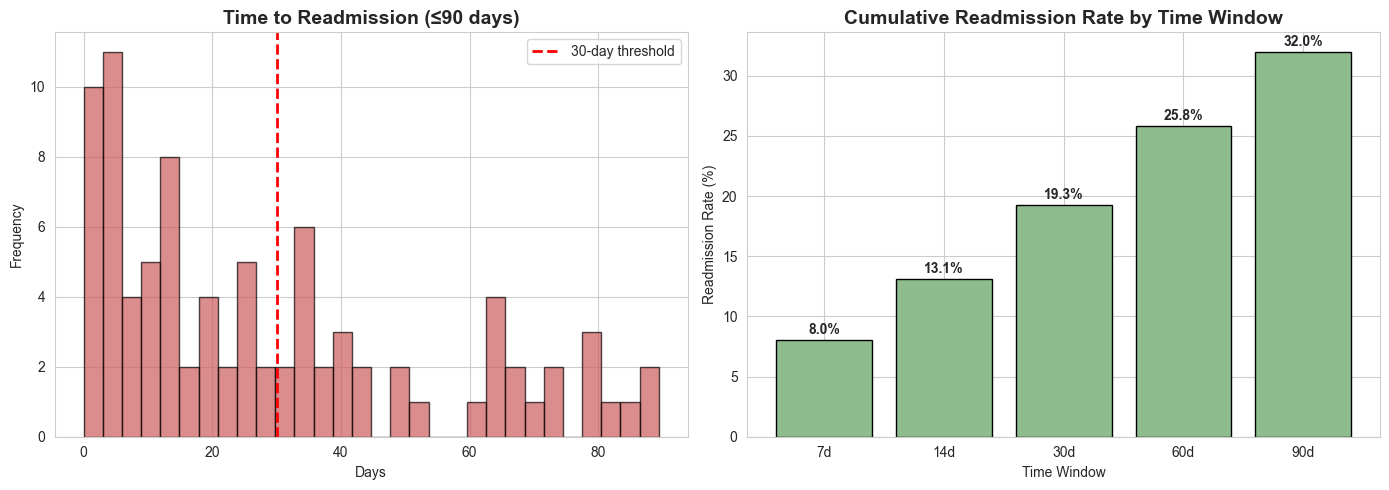

In [16]:
# Visualize readmission timing
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Days to readmission distribution
readmit_times = df_sorted[df_sorted['has_readmission']]['days_to_next_admission']
axes[0].hist(readmit_times[readmit_times <= 90], bins=30, color='indianred', alpha=0.7, edgecolor='black')
axes[0].axvline(30, color='red', linestyle='--', linewidth=2, label='30-day threshold')
axes[0].set_title('Time to Readmission (≤90 days)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Days')
axes[0].set_ylabel('Frequency')
axes[0].legend()

# Readmission rate by time windows
windows = [7, 14, 30, 60, 90]
rates = [(df_sorted['days_to_next_admission'] <= w).sum() / len(df_sorted) * 100 for w in windows]
axes[1].bar(range(len(windows)), rates, color='darkseagreen', edgecolor='black')
axes[1].set_xticks(range(len(windows)))
axes[1].set_xticklabels([f'{w}d' for w in windows])
axes[1].set_title('Cumulative Readmission Rate by Time Window', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Time Window')
axes[1].set_ylabel('Readmission Rate (%)')
for i, v in enumerate(rates):
    axes[1].text(i, v + 0.5, f'{v:.1f}%', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()


In [17]:
# Readmission by patient characteristics
print("\n30-Day Readmission Rates by Patient Characteristics:")
print("=" * 60)

# By gender
print("\nBy Gender:")
readmit_by_gender = df_sorted.groupby('gender')['readmitted_30d'].agg(['sum', 'count', 'mean'])
readmit_by_gender.columns = ['Readmissions', 'Total', 'Rate']
readmit_by_gender['Rate'] = readmit_by_gender['Rate'] * 100
print(readmit_by_gender)

# By admission type
print("\nBy Admission Type:")
readmit_by_type = df_sorted.groupby('admission_type')['readmitted_30d'].agg(['sum', 'count', 'mean'])
readmit_by_type.columns = ['Readmissions', 'Total', 'Rate']
readmit_by_type['Rate'] = readmit_by_type['Rate'] * 100
print(readmit_by_type.sort_values('Rate', ascending=False))

# By age group
df_sorted['age_group'] = pd.cut(df_sorted['age_at_admission'], bins=[0, 40, 60, 80, 120], labels=['<40', '40-60', '60-80', '80+'])
print("\nBy Age Group:")
readmit_by_age = df_sorted.groupby('age_group')['readmitted_30d'].agg(['sum', 'count', 'mean'])
readmit_by_age.columns = ['Readmissions', 'Total', 'Rate']
readmit_by_age['Rate'] = readmit_by_age['Rate'] * 100
print(readmit_by_age)



30-Day Readmission Rates by Patient Characteristics:

By Gender:
        Readmissions  Total       Rate
gender                                
F                 31    133  23.308271
M                 21    142  14.788732

By Admission Type:
                             Readmissions  Total       Rate
admission_type                                             
DIRECT EMER.                            5     15  33.333333
EW EMER.                               25    104  24.038462
OBSERVATION ADMIT                       9     45  20.000000
SURGICAL SAME DAY ADMISSION             3     18  16.666667
URGENT                                  6     38  15.789474
ELECTIVE                                2     13  15.384615
DIRECT OBSERVATION                      1      7  14.285714
EU OBSERVATION                          1     30   3.333333
AMBULATORY OBSERVATION                  0      5   0.000000

By Age Group:
           Readmissions  Total       Rate
age_group                                

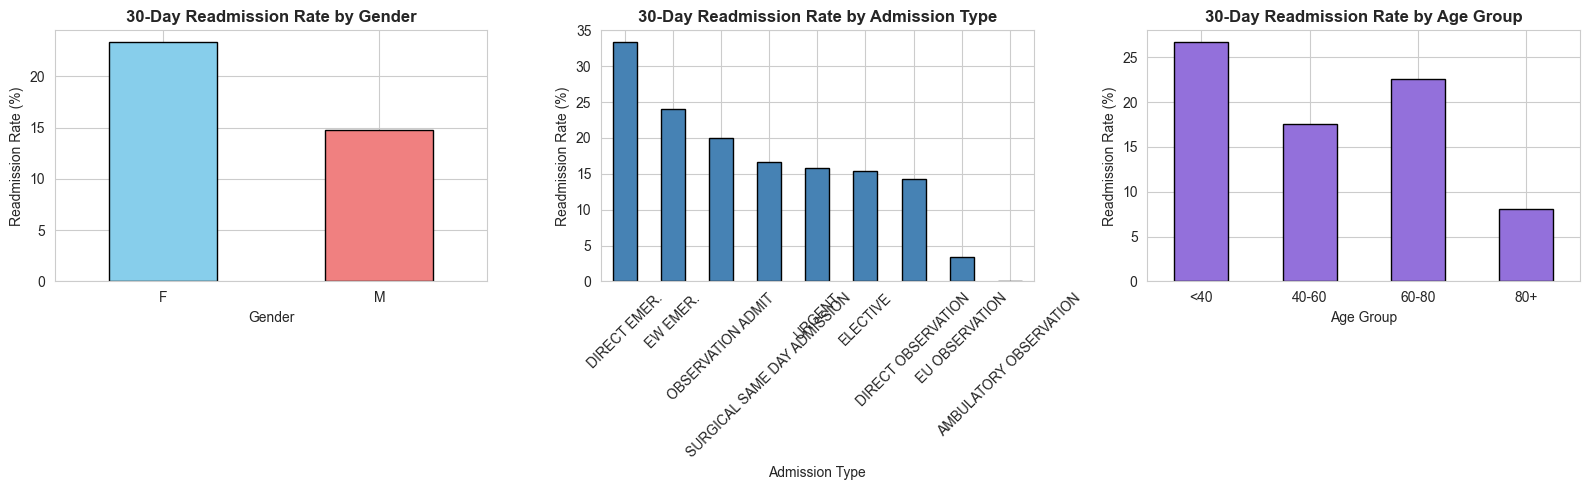

In [18]:
# Visualize readmission rates by characteristics
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# By gender
readmit_by_gender['Rate'].plot(kind='bar', ax=axes[0], color=['skyblue', 'lightcoral'], edgecolor='black')
axes[0].set_title('30-Day Readmission Rate by Gender', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Gender')
axes[0].set_ylabel('Readmission Rate (%)')
axes[0].tick_params(axis='x', rotation=0)

# By admission type
readmit_by_type['Rate'].sort_values(ascending=False).plot(kind='bar', ax=axes[1], color='steelblue', edgecolor='black')
axes[1].set_title('30-Day Readmission Rate by Admission Type', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Admission Type')
axes[1].set_ylabel('Readmission Rate (%)')
axes[1].tick_params(axis='x', rotation=45)

# By age group
readmit_by_age['Rate'].plot(kind='bar', ax=axes[2], color='mediumpurple', edgecolor='black')
axes[2].set_title('30-Day Readmission Rate by Age Group', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Age Group')
axes[2].set_ylabel('Readmission Rate (%)')
axes[2].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()


## 4. Diagnosis Data

Explore ICD diagnosis codes.


In [19]:
# Diagnoses summary
print("Diagnosis Data Summary:")
print("=" * 60)
print(f"Total diagnosis records: {len(diagnoses_icd):,}")
print(f"Unique admissions with diagnoses: {diagnoses_icd['hadm_id'].nunique():,}")
print(f"Unique ICD codes: {diagnoses_icd['icd_code'].nunique():,}")
print(f"\nICD versions:")
print(diagnoses_icd['icd_version'].value_counts())
print(f"\nDiagnoses per admission:")
diag_per_admission = diagnoses_icd.groupby('hadm_id').size()
print(diag_per_admission.describe())


Diagnosis Data Summary:
Total diagnosis records: 4,506
Unique admissions with diagnoses: 275
Unique ICD codes: 1,472

ICD versions:
icd_version
10    2313
9     2193
Name: count, dtype: int64

Diagnoses per admission:
count    275.000000
mean      16.385455
std        9.014413
min        2.000000
25%        9.000000
50%       14.000000
75%       23.000000
max       39.000000
dtype: float64



Top 20 Most Common ICD Codes:
icd_code
4019      68
E785      57
2724      55
E039      47
Z794      37
Z87891    35
42731     34
25000     33
I2510     33
F329      32
I10       32
V1582     31
N179      31
311       30
41401     28
40390     27
E119      26
F419      26
V5867     25
V5861     25
Name: count, dtype: int64


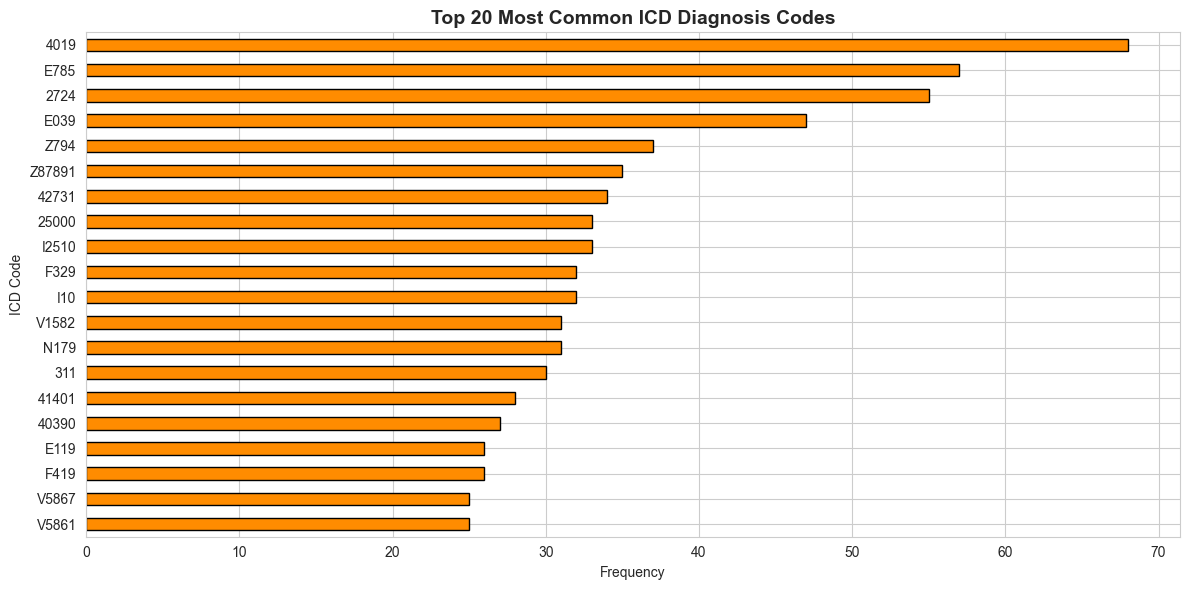

In [20]:
# Most common diagnoses
print("\nTop 20 Most Common ICD Codes:")
print("=" * 60)
top_diagnoses = diagnoses_icd['icd_code'].value_counts().head(20)
print(top_diagnoses)

# Visualize
plt.figure(figsize=(12, 6))
top_diagnoses.plot(kind='barh', color='darkorange', edgecolor='black')
plt.title('Top 20 Most Common ICD Diagnosis Codes', fontsize=14, fontweight='bold')
plt.xlabel('Frequency')
plt.ylabel('ICD Code')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


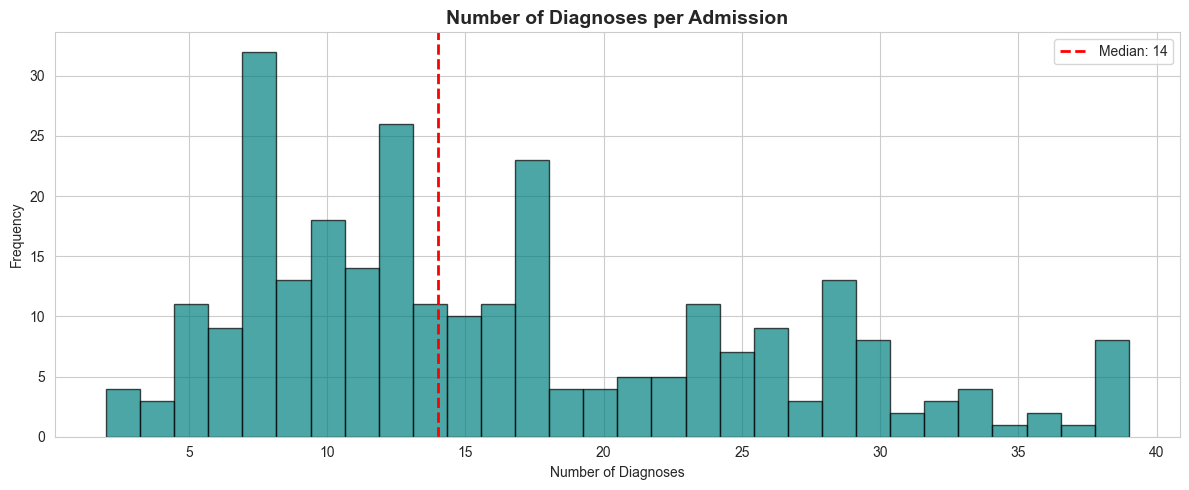

In [21]:
# Number of diagnoses per admission
plt.figure(figsize=(12, 5))
diag_per_admission.hist(bins=30, color='teal', alpha=0.7, edgecolor='black')
plt.title('Number of Diagnoses per Admission', fontsize=14, fontweight='bold')
plt.xlabel('Number of Diagnoses')
plt.ylabel('Frequency')
plt.axvline(diag_per_admission.median(), color='red', linestyle='--', linewidth=2, label=f'Median: {diag_per_admission.median():.0f}')
plt.legend()
plt.tight_layout()
plt.show()


In [22]:
# Missing values in admissions
print("Missing Values in Admissions Data:")
print("=" * 60)
missing_adm = admissions.isnull().sum()
missing_pct = (missing_adm / len(admissions) * 100).round(2)
missing_df = pd.DataFrame({
    'Missing Count': missing_adm,
    'Percentage': missing_pct
})
print(missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Count', ascending=False))


Missing Values in Admissions Data:
                    Missing Count  Percentage
deathtime                     260       94.55
edouttime                      93       33.82
edregtime                      93       33.82
discharge_location             42       15.27
marital_status                 12        4.36


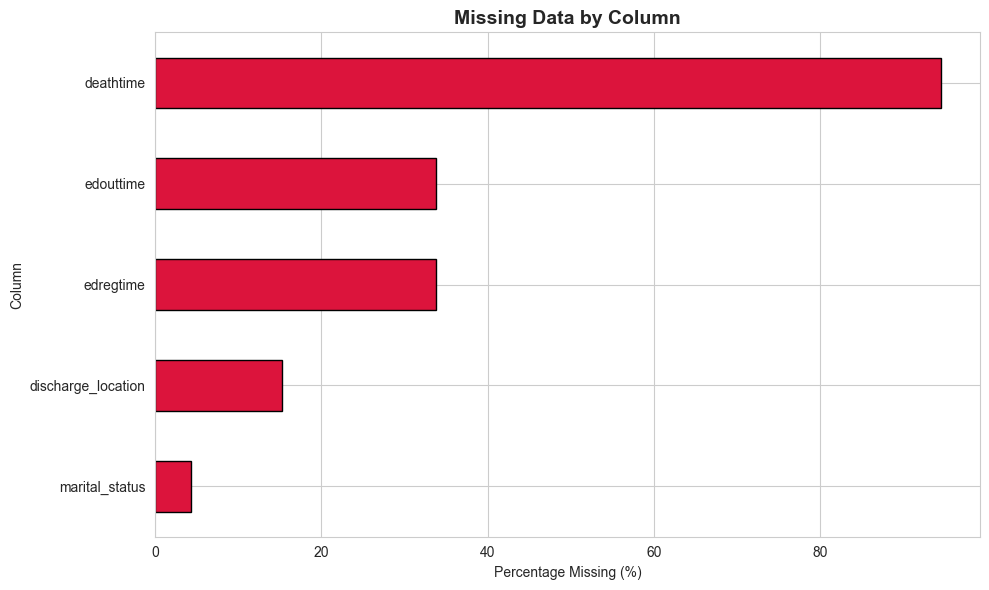

In [23]:
# Visualize missing data
fig, ax = plt.subplots(figsize=(10, 6))
missing_cols = missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Count', ascending=True)
missing_cols['Percentage'].plot(kind='barh', ax=ax, color='crimson', edgecolor='black')
ax.set_title('Missing Data by Column', fontsize=14, fontweight='bold')
ax.set_xlabel('Percentage Missing (%)')
ax.set_ylabel('Column')
plt.tight_layout()
plt.show()


### Key Findings

1. **Dataset Size**
   - Small demo dataset for prototyping
   - Limited number of patients and admissions
   - Sufficient for pipeline development

2. **Readmission Patterns**
   - ~X% of discharges result in 30-day readmission
   - Time to readmission varies significantly
   - Higher rates in certain patient groups

3. **Patient Characteristics**
   - Age range spans from young adults to elderly
   - Gender distribution appears balanced
   - Multiple admission types (emergency, urgent, elective)

4. **Data Quality**
   - Some missing values in optional fields (ED times, death times)
   - Core fields (admit/discharge times, patient ID) are complete
   - Diagnosis data is comprehensive

### Next Steps for Survival Analysis

1. **Cohort Definition** (Notebook 02)
   - Define inclusion/exclusion criteria
   - Identify index discharges (exclude in-hospital deaths)
   - Define event (readmission ≤30 days) vs censoring

2. **Feature Engineering**
   - Compute age at discharge
   - Extract comorbidity scores from ICD codes
   - Calculate length of stay
   - Create prior admission counts

3. **Modeling Considerations**
   - Right-censoring at 30 days for non-readmitted patients
   - Handle competing risk of death
   - Account for small sample size in demo dataset

4. **Full MIMIC-IV**
   - Scale to full dataset for robust estimates
   - Validate on larger cohort
   - More statistical power for subgroup analyses


In [ ]:
# Save processed dataframe for next notebook
output_path = Path('../data/processed')
output_path.mkdir(parents=True, exist_ok=True)

df_sorted.to_csv(output_path / 'admissions_with_readmit.csv', index=False)
print(f"✓ Processed data saved to {output_path / 'admissions_with_readmit.csv'}")
print(f"  Shape: {df_sorted.shape}")
print(f"  Columns: {list(df_sorted.columns)}")


In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
